# Kunskapskontroll 2

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

# Downloading the data and inspecting it

In [34]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print(mnist.DESCR)

C:\Users\jakob\anaconda3\envs\DS_PyStat\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [35]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [36]:
# Start with less data to speed up training for hyperparameter fine-tuning. 
X_train_small = X[:10000]
y_train_small = y[:10000]
X_val_small = X[10000:12000]
y_val_small = y[10000:12000]

# Using full data set for training (50 000), validation (10 000) and testing (10 000)
X_train = X[:50000]
y_train = y[:50000]
X_val = X[50000:60000]
y_val = y[50000:60000]
X_train_val = X[:60000] # Final training set (training and validation data combined) for evaluation on Test data. 
y_train_val = y[:60000]

X_test = X[60000:]
y_test = y[60000:]

In [37]:
# Standardizing the data.
scaler = StandardScaler()

# Standardaizing small data set
X_train_small_scaled = scaler.fit_transform(X_train_small)
X_val_small_scaled = scaler.transform(X_val_small)

# Standardaizing full data set
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Only transforming the validation data. 
X_test_scaled = scaler.transform(X_test)  # Only transforming the test data. 

# Exploring and understanding the data

In [38]:
# How the digits are built. 
# Shape of training data set.
print("Training data set:", X_train.shape)
print(type(X_train))

Training data set: (50000, 784)
<class 'numpy.ndarray'>


In [39]:
# Each digit consists of 784 features (pixels).
# Each value represents a pixel of the image
print("Min pixel value:", np.min(X_train_small[0]))
print("Max pixel value:", np.max(X_train_small[0]))

Min pixel value: 0.0
Max pixel value: 255.0


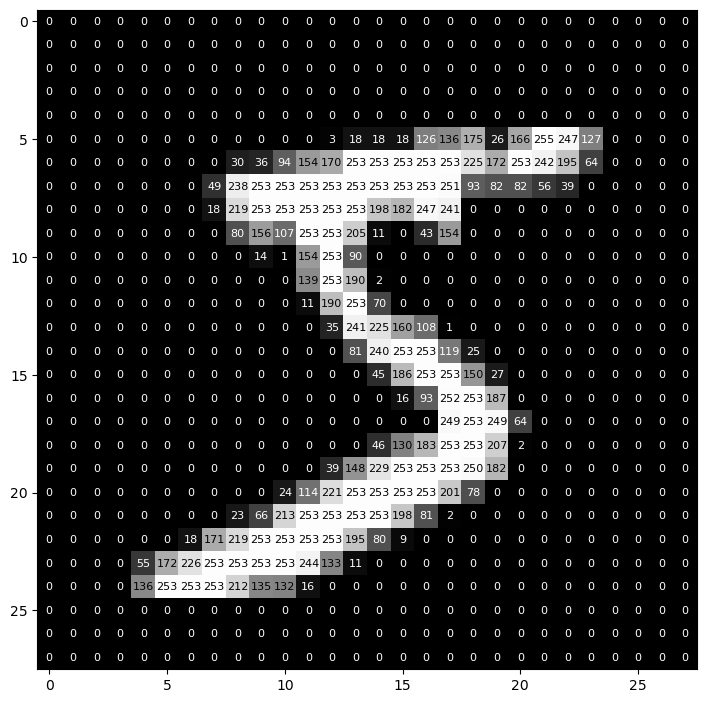

In [40]:
# Display first digit in training set, reshaped to 28x28 to resemble the digit image.
digit = X_train_small[0].reshape(28, 28)

digit_plot = plt.figure(figsize = (80, 80))
sub = digit_plot.add_subplot(784)
sub.imshow(digit, cmap='gray')

for x in range(28):     
    for y in range(28):      # iterating through rows and columns
        val = int(digit[x][y].item())     # display value as intiger (no decimals)
        sub.annotate(str(val), xy=(y, x), size=8,      # placing value in x,y
                     ha='center', va='center',          # centering text
                     color='w' if digit[x][y].item() < 130 else 'k')  # white text on dark background and black text on bright.


In [41]:
# The values represents the color intensity for each pixel
# With only 1 color channel the pixel values are typically used as grayscale, with 0 as black and 255 as white.

In [42]:
# each pixel consists of a number (0-255). When shown as grayscale, 0 represents black and 255 represents white.


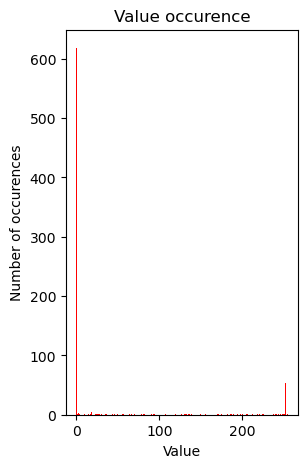

In [43]:
# Plot histogram to see the distribution of values
sample = X_train_small[0]
plt.figure(figsize=(3, 5))
plt.xlabel("Value")
plt.ylabel("Number of occurences")
plt.title("Value occurence")
plt.hist(sample, bins=256, color='r')
plt.show()

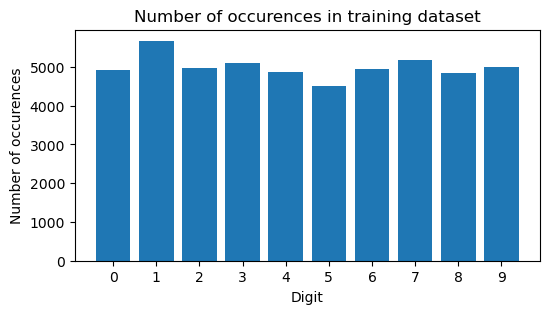

In [44]:
# Check possible imbalance in training set
# plot number of occurences for each digit in training set

values, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(6, 3))
plt.bar(values, counts)
plt.xticks(values)
plt.xlabel("Digit")
plt.ylabel("Number of occurences")
plt.title("Number of occurences in training dataset")
plt.show()

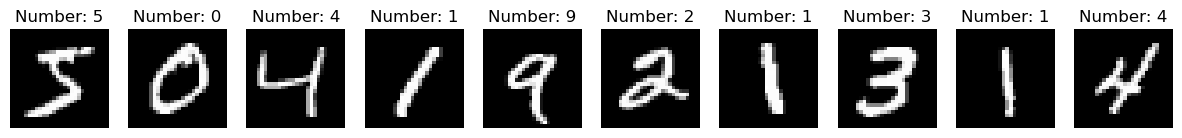

In [45]:
# Plotting the first 10 digits of the training set.
fig = plt.figure(figsize=(15, 3))

for n in range(10):
    fig.add_subplot(1, 10, n+1)
    digit_image = X_train[n].reshape(28, 28)
    plt.imshow(digit_image, cmap='gray')
    plt.title("Number: %d" %y_train[n])
    plt.axis("off")

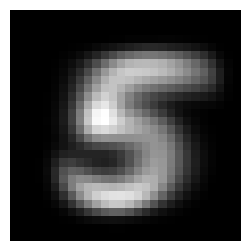

In [46]:
# The "mean" digit 5 in the small training set
plt.figure(figsize=(3,3))
avg_img = np.average(X_train[y_train==5], 0)
plt.imshow(avg_img.reshape((28,28)), cmap='gray') 
plt.axis('off')
plt.show()

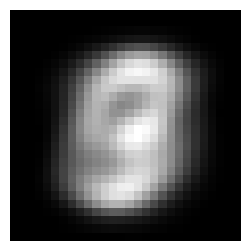

In [47]:
# The "mean" digit (of all) in the small training set
plt.figure(figsize=(3,3))
avg_dig = np.average(X_train, 0)
plt.imshow(avg_dig.reshape((28,28)), cmap='gray') 
plt.axis('off')
plt.show()

In [48]:
# We see that the "mean digit" is surounded by a dark frame. 
# This indicates that the outskirts are genarally not affected.
# Which means that those pixels are not as important when training the model. 
# We can then use PCA to reduce the number of features.

# Evaluating models on small data set for the purpose of hyperparameter-tuning.




In [49]:
# Using PCA to reduce model fitting time when tuning for hyperparameters
# Try PCA with different number of components to evaluate the effect on scoring
svc_try = SVC(random_state = 42)
n_comp = [0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

for n in n_comp:
    pca_try = PCA(n_components=n)
    pca_try.fit(X_train_small_scaled)
    print(f"{n*100} % results in {pca_try.n_components_} number of components")

75.0 % results in 98 number of components
80.0 % results in 122 number of components
85.0 % results in 153 number of components
90.0 % results in 198 number of components
95.0 % results in 283 number of components
99.0 % results in 489 number of components


In [50]:
pca = PCA(n_components=0.95)  # Preserving 95 % of the variance
X_train_small_reduced = pca.fit_transform(X_train_small_scaled)

### SVM (Support Vector Machine)

In [51]:
#### TAKES ABOUT 20 MINUTES TO RUN ####

# SVM using GridsearchCV to get best parameters
svm_clf = SVC(random_state = 42) # Using a Support Vector Classifier

# Specify a hyperparameter grid to try different hyperparameters
svm_param_grid = {
    'kernel': ['rbf', 'poly'],
    'gamma': [1, 1.5, 2],
    'C': [0.5, 1, 1.5]
}

# Use GridSearchCV and fit the model with the hyperparameter grid
gs_svm = GridSearchCV(estimator = svm_clf, param_grid = svm_param_grid, cv=3)
gs_svm.fit(X_train_small_reduced, y_train_small)


GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [0.5, 1, 1.5], 'gamma': [1, 1.5, 2],
                         'kernel': ['rbf', 'poly']})

In [52]:
# Get the results from the grid search

print("Best estimator:", gs_svm.best_estimator_)  # check best estimator 
pd.DataFrame(gs_svm.cv_results_)  # analyze the grid search results

Best estimator: SVC(C=0.5, gamma=1, kernel='poly', random_state=42)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,21.430275,0.353850,6.679524,0.051682,0.5,1,rbf,"{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}",0.112777,0.112811,0.112511,0.1127,0.000134,10
1,5.223846,0.143519,1.527479,0.033808,0.5,1,poly,"{'C': 0.5, 'gamma': 1, 'kernel': 'poly'}",0.952010,0.957096,0.940594,0.9499,0.006900,1
2,22.628118,0.375793,6.882851,0.002269,0.5,1.5,rbf,"{'C': 0.5, 'gamma': 1.5, 'kernel': 'rbf'}",0.112777,0.112811,0.112511,0.1127,0.000134,10
3,5.240079,0.109921,1.553547,0.053302,0.5,1.5,poly,"{'C': 0.5, 'gamma': 1.5, 'kernel': 'poly'}",0.952010,0.957096,0.940594,0.9499,0.006900,1
4,22.922447,0.435508,6.992333,0.049085,0.5,2,rbf,"{'C': 0.5, 'gamma': 2, 'kernel': 'rbf'}",0.112777,0.112811,0.112511,0.1127,0.000134,10
5,5.589325,0.250868,1.680457,0.126317,0.5,2,poly,"{'C': 0.5, 'gamma': 2, 'kernel': 'poly'}",0.952010,0.957096,0.940594,0.9499,0.006900,1
6,22.084247,0.194930,6.698244,0.044414,1,1,rbf,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.112777,0.112811,0.112511,0.1127,0.000134,10
7,5.119554,0.114101,1.527561,0.058722,1,1,poly,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",0.952010,0.957096,0.940594,0.9499,0.006900,1
8,22.627694,0.532328,6.843183,0.012779,1,1.5,rbf,"{'C': 1, 'gamma': 1.5, 'kernel': 'rbf'}",0.112777,0.112811,0.112511,0.1127,0.000134,10
9,5.305125,0.159743,1.535625,0.029422,1,1.5,poly,"{'C': 1, 'gamma': 1.5, 'kernel': 'poly'}",0.952010,0.957096,0.940594,0.9499,0.006900,1


In [53]:
# The grid search results shows that all models with kernel = 'poly' have the highest score.

In [54]:
# Choose one of the top ranked models with shortest mean_fit_time
# svc_small = SVC(C = 1, gamma = 1.5, kernel = 'poly', random_state = 42).fit(X_train_small_scaled, y_train_small)

# Predict the scaled and reduced validation data, compute the accuracy score, visualize the confusion matrix
y_pred_svc_val_small = gs_svm.predict(pca.transform(X_val_small_scaled))  
score_svc_val_small = accuracy_score(y_val_small, y_pred_svc_val_small)  
print("SVC accuracy score on small data set:", score_svc_val_small)

SVC accuracy score on small data set: 0.9615


### Random Forest Classifier

In [55]:
# Random Forest hyperparameter fine-tuning
# Specify a hyperparameter grid
rf_param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1]
}

# Use GridSearchCV and fit the model with the hyperparameter grid
rf_clf = RandomForestClassifier(random_state = 42)
gs_rf = GridSearchCV(estimator = rf_clf, param_grid = rf_param_grid, cv=3)
gs_rf.fit(X_train_small_scaled, y_train_small)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100]})

In [56]:
print("Best estimator:", gs_rf.best_estimator_)  # check best estimator 
print("Best parameters:", gs_rf.best_params_)  # check best parameters
pd.DataFrame(gs_rf.cv_results_)  # analyze the grid search results

Best estimator: RandomForestClassifier(max_depth=10, random_state=42)
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.112471,0.009676,0.061483,0.007233,3,1,2,100,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.748350,0.758776,0.735674,0.7476,0.009446,7
1,1.204184,0.070435,0.062760,0.008494,3,1,5,100,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.748350,0.758776,0.735674,0.7476,0.009446,7
2,1.116921,0.016303,0.055127,0.000670,3,1,10,100,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.748350,0.758776,0.735674,0.7476,0.009446,7
3,1.857145,0.008887,0.092131,0.002112,5,1,2,100,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.854829,0.864086,0.845185,0.8547,0.007717,6
4,1.880797,0.008232,0.095201,0.003654,5,1,5,100,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.853929,0.864086,0.846685,0.8549,0.007137,5
5,1.852707,0.008184,0.088999,0.000589,5,1,10,100,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.853329,0.863486,0.847885,0.8549,0.006465,4
6,4.022686,0.026681,0.150123,0.021293,10,1,2,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.936413,0.939394,0.925293,0.9337,0.006068,1
7,3.978067,0.050222,0.151357,0.010878,10,1,5,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.935213,0.935794,0.927993,0.9330,0.003548,2
8,3.812879,0.011885,0.133320,0.002251,10,1,10,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.930414,0.932793,0.924392,0.9292,0.003535,3


In [57]:
# Predict the scaled validation data, compute the accuracy score, visualize the confusion matrix
y_pred_rf_val_small = gs_rf.predict(X_val_small_scaled)  
score_rf_val_small = accuracy_score(y_val_small, y_pred_rf_val_small)  
print("RF accuracy score:", score_rf_val_small)

# Visualize the confusion matrix

RF accuracy score: 0.9385


### KNN (Nearest Neighbors Classifier)

In [58]:
# KNN testing number of neighbors
neighbors_list = np.arange(1, 15, 1)
accuracy_list = []
for test_number in neighbors_list:
    mod = KNeighborsClassifier(n_neighbors = test_number)
    predictions = mod.fit(X_train_small_scaled, y_train_small).predict(X_val_small_scaled)
    accuracy = accuracy_score(y_val_small, predictions)
    accuracy_list.append(accuracy)
result_df = pd.DataFrame({'neighbors': neighbors_list, 'accuracy score': accuracy_list})
print(result_df)

    neighbors  accuracy score
0           1          0.9045
1           2          0.8930
2           3          0.9145
3           4          0.9120
4           5          0.9115
5           6          0.9145
6           7          0.9155
7           8          0.9120
8           9          0.9095
9          10          0.9060
10         11          0.9070
11         12          0.9040
12         13          0.9060
13         14          0.9070


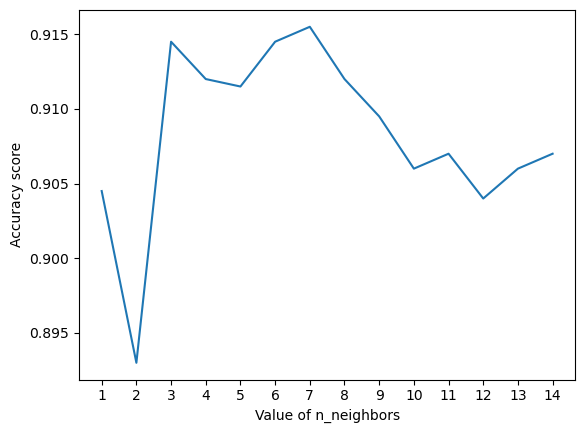

In [59]:
# Examine score for different n_neighbors
plt.plot(neighbors_list, accuracy_list)
plt.xticks(neighbors_list)
plt.xlabel('Value of n_neighbors')
plt.ylabel('Accuracy score')
plt.show()

In [60]:
# KNN hyperparameter fine-tuning
knn_param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7, 8],
    'weights': ['uniform', 'distance']
}

# Use GridSearchCV and fit the model with the hyperparameter grid
knn_clf = KNeighborsClassifier()
gs_knn = GridSearchCV(estimator = knn_clf, param_grid = knn_param_grid, cv=3)
gs_knn.fit(X_train_small_scaled, y_train_small)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8],
                         'weights': ['uniform', 'distance']})

In [61]:
print("Best estimator:", gs_knn.best_estimator_)  # check best estimator 
print("Best parameters:", gs_knn.best_params_)  # check best parameters
pd.DataFrame(gs_knn.cv_results_)  # analyze the grid search results

Best estimator: KNeighborsClassifier(n_neighbors=4, weights='distance')
Best parameters: {'n_neighbors': 4, 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029325,0.002064,0.399575,0.009115,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.903119,0.902190,0.890189,0.8985,0.005889,8
1,0.028498,0.004848,0.389248,0.007761,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.906719,0.908791,0.893189,0.9029,0.006918,3
2,0.024981,0.003670,0.373254,0.006202,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",0.899820,0.903390,0.889889,0.8977,0.005712,11
3,0.027660,0.002114,0.391695,0.006327,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.909118,0.909691,0.899190,0.9060,0.004821,1
4,0.027681,0.003258,0.406488,0.002722,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.900420,0.905491,0.889589,0.8985,0.006632,7
5,0.031009,0.001163,0.408534,0.006584,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.902519,0.909091,0.891689,0.9011,0.007175,5
6,0.027645,0.002858,0.417451,0.011519,6,uniform,"{'n_neighbors': 6, 'weights': 'uniform'}",0.898620,0.904590,0.890489,0.8979,0.005779,10
7,0.025775,0.003296,0.414545,0.017364,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.907019,0.907591,0.894989,0.9032,0.005810,2
8,0.027679,0.002910,0.412139,0.007062,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.897720,0.906391,0.890789,0.8983,0.006382,9
9,0.027952,0.005518,0.392215,0.007141,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.898320,0.905491,0.894089,0.8993,0.004706,6


In [62]:
# Predict the scaled validation data, compute the accuracy score, visualize the confusion matrix
y_pred_knn_val_small = gs_knn.predict(X_val_small_scaled)  
score_knn_val_small = accuracy_score(y_val_small, y_pred_knn_val_small)  
print("KNN accuracy score:", score_knn_val_small)

KNN accuracy score: 0.92


## Model evaluation with full training set

In [63]:
#SVM
svm = gs_svm.best_estimator_

#RF
rf = gs_rf.best_estimator_

#KNN
knn = gs_knn.best_estimator_

In [64]:
# Compare fine-tuned models on full training set and evaluate on validation set

clfs = [('SVC', svm), ('Random Forest', rf), ('KNN', knn)]
preds = dict(clfs)

### This takes about 15 minutes ### 
for name, clf in clfs:
    pred = clf.fit(X_train_scaled, y_train).predict(X_val_scaled)
    preds[name] = pred
    score = accuracy_score(y_val, pred)
    print(f"{name}, accuracy score: {score}")

SVC, accuracy score: 0.9793
Random Forest, accuracy score: 0.9512
KNN, accuracy score: 0.9534


In [65]:
# classification report for SVC
print(classification_report(y_val, preds['SVC']))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       991
           1       0.99      0.99      0.99      1064
           2       0.98      0.98      0.98       990
           3       0.97      0.97      0.97      1030
           4       0.98      0.98      0.98       983
           5       0.99      0.96      0.98       915
           6       0.99      1.00      0.99       967
           7       0.98      0.98      0.98      1090
           8       0.96      0.98      0.97      1009
           9       0.97      0.96      0.97       961

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [66]:
# classification report for Random Forest
print(classification_report(y_val, preds['Random Forest']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       991
           1       0.96      0.98      0.97      1064
           2       0.96      0.95      0.95       990
           3       0.95      0.95      0.95      1030
           4       0.96      0.93      0.95       983
           5       0.97      0.92      0.95       915
           6       0.97      0.98      0.98       967
           7       0.95      0.95      0.95      1090
           8       0.94      0.93      0.93      1009
           9       0.88      0.93      0.90       961

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [67]:
# classification report for KNN
print(classification_report(y_val, preds['KNN']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       991
           1       0.96      0.99      0.98      1064
           2       0.96      0.95      0.96       990
           3       0.93      0.95      0.94      1030
           4       0.96      0.94      0.95       983
           5       0.95      0.93      0.94       915
           6       0.96      0.98      0.97       967
           7       0.96      0.95      0.96      1090
           8       0.97      0.91      0.94      1009
           9       0.92      0.93      0.93       961

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



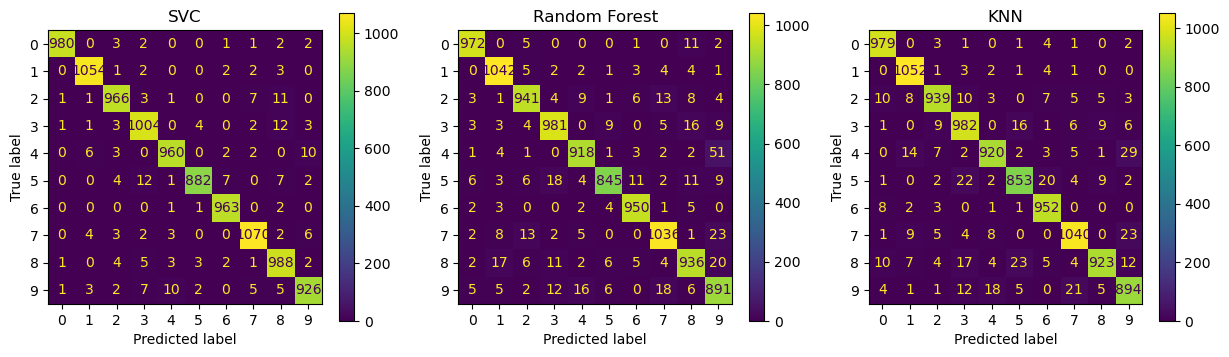

In [68]:
# Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for name in preds:
    ax[i].set_title(name)
    ConfusionMatrixDisplay(confusion_matrix(y_val, preds[name])).plot(ax=ax[i])
    i += 1
plt.show()

In [69]:
# SVC is the better one out of the three tested models
# Lowest Recall score (0.96) is for digit 9, meaning 9 is more difficult to predict correctly
# Lowest Precision score (0.96) is for digit 8, meaning 8 is more often predicted incorrectly


### Voting Classifier

In [70]:
# Create a voting classifier, train it on the training data and evaluate it on the validation data using the score method.
### This takes about 20 minutes ###

voting_clf = VotingClassifier(clfs)
pred_vot = voting_clf.fit(X_train_scaled, y_train).predict(X_val_scaled)
score_vot = accuracy_score(y_val, pred_vot)
print(f"Accuracy score: {score_vot}")

Accuracy score: 0.9741


In [71]:
# classification report
print(classification_report(y_val, pred_vot))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       991
           1       0.97      0.99      0.98      1064
           2       0.97      0.98      0.98       990
           3       0.96      0.98      0.97      1030
           4       0.98      0.97      0.97       983
           5       0.98      0.96      0.97       915
           6       0.98      0.99      0.99       967
           7       0.98      0.97      0.97      1090
           8       0.97      0.96      0.97      1009
           9       0.96      0.95      0.95       961

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



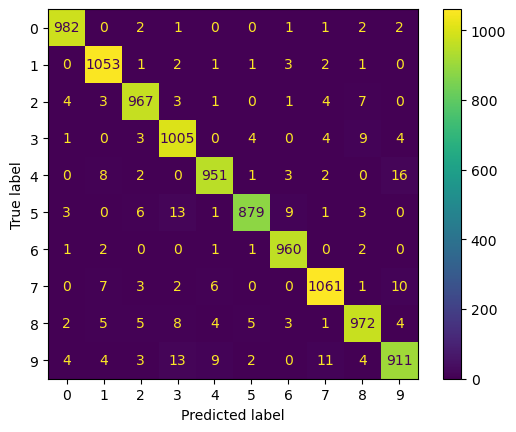

In [76]:
# Confusion Matrix for Voting Classifier
cm_vot = confusion_matrix(y_val, pred_vot)
ConfusionMatrixDisplay(cm_vot).plot()

In [77]:
# Best model is SVC
best_model = svm

## Model evaluation on Test Data

In [78]:
### This takes about 10 minutes ###
# Train the best model on combined training/validation set
pipeline = Pipeline([('Scaler', StandardScaler()), ('Classifier', svm)])
model = pipeline.fit(X_train_val, y_train_val)

In [79]:
# Save pipeline as a file to uses for transformation and prediction in Streamlit
joblib.dump(model, 'model.joblib')

['model.joblib']

In [80]:
# Evaluate on the scaled test data and calculate accuracy score.
y_pred_test = model.predict(X_test)
model_score = accuracy_score(y_test, y_pred_test)
print("Accuracy score:", model_score)

Accuracy score: 0.9783


In [81]:
# comparing test score with validation score
print("Accuracy score on validation set: 0.9793")
print("Accuracy score on test set:", model_score)

Accuracy score on validation set: 0.9793
Accuracy score on test set: 0.9783


In [82]:
# The accuracy score on the test data is similar to the score on the validation data. No over-/underfitting.

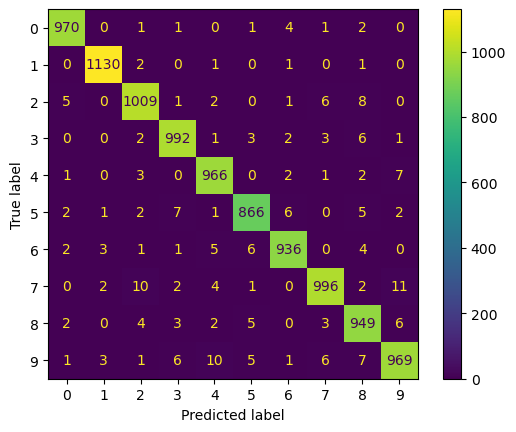

In [83]:
# Confusion Matrix on test data
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm).plot()

In [84]:
# Classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [85]:
# Calculate false predictions
for n in range(10):
    print(f"Digit {n}: {cm.sum(axis=1)[n] - cm[n][n]} false predictions ({(cm.sum(axis=1)[n] - cm[n][n]) / cm.sum(axis=1)[n] * 100:.2f}%)")

Digit 0: 10 false predictions (1.02%)
Digit 1: 5 false predictions (0.44%)
Digit 2: 23 false predictions (2.23%)
Digit 3: 18 false predictions (1.78%)
Digit 4: 16 false predictions (1.63%)
Digit 5: 26 false predictions (2.91%)
Digit 6: 22 false predictions (2.30%)
Digit 7: 32 false predictions (3.11%)
Digit 8: 25 false predictions (2.57%)
Digit 9: 40 false predictions (3.96%)


In [86]:
# It seems like the most difficult number to predict is 9


In [87]:
# Show wrongly predicted images
y_wrong_i = [i for i,v in enumerate(y_pred_test) if y_pred_test[i]!=y_test[i]]
print("Total number of wrongly predicted digits:", len(y_wrong_i))

y_wrong_9 = [i for i,v in enumerate(y_pred_test) if y_pred_test[i]!=y_test[i]==9]
print("Total number of wrongly predicted digit 9:", len(y_wrong_9))

Total number of wrongly predicted digits: 217
Total number of wrongly predicted digit 9: 40


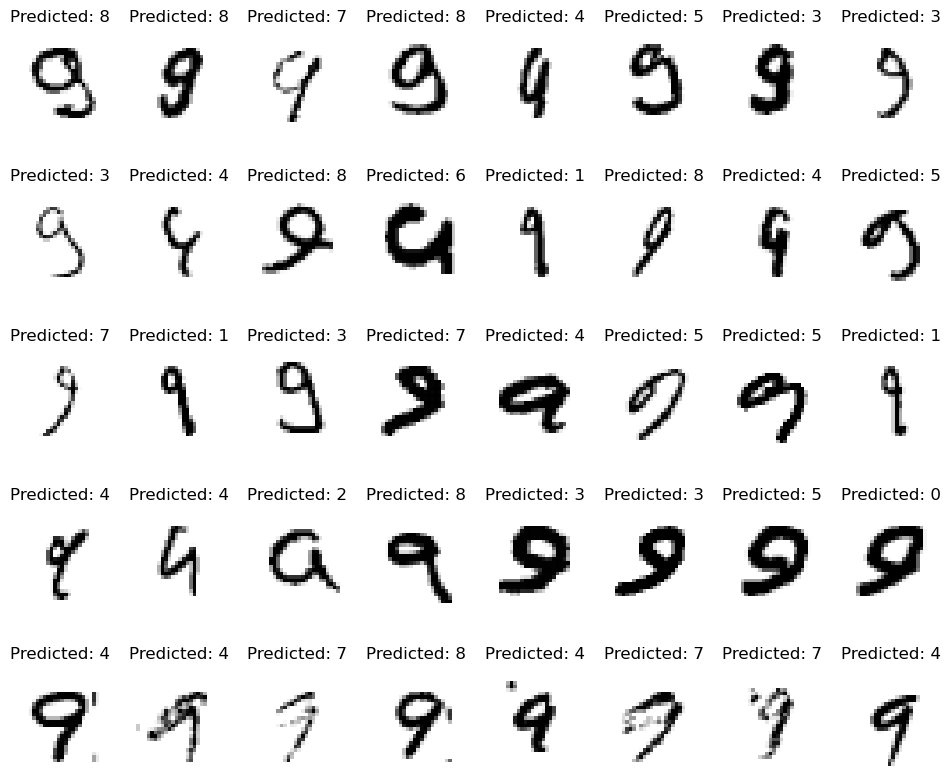

In [88]:
# Plot wrongly predictions for digit 9
fig = plt.figure(figsize=(12, 10))
r = 5
c = 8

for m in range(0, len(y_wrong_9)):
    ix = y_wrong_9[m]
    wrong_dig = X_test[ix]
    wrong_dig_image = wrong_dig.reshape(28, 28)
    fig.add_subplot(r, c, m+1)
    plt.imshow(wrong_dig_image, cmap=mpl.cm.binary)
    plt.axis("off")
    plt.title(f"Predicted: {y_pred_test[ix]}")